-------------------------------------------------------------------

### Cargar librerias

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

* Cargar archivo CSV

In [2]:
df = pd.read_csv("data/AB_NYC_2019.csv")

* Fecha: probar a descomponer la fecha en campos año mes y día con pandas es decir, en 3 columnas, por ejemplo usando to_datetime de pandas y los accesores de fecha para extraer año mes y día

* Quitar columnas: id, name, host_id, host_name, last_review 

In [3]:
columnas_a_eliminar = ['id', 'name', 'host_id', 'host_name', 'last_review']
# Verificar si las columnas existen en el DataFrame antes de eliminarlas
columnas_existentes = [col for col in columnas_a_eliminar if col in df.columns]
df = df.drop(columns=columnas_existentes)

df.head(3)

neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
0    149               1                  9               0.21   
1    225               1                 45               0.38   
2    150               3                  0                NaN   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365

In [4]:
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

* Gestión de nulos:
    * reviews_per_month si es nan se puede dejar a 0

In [5]:
df = df.fillna(0)

In [6]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#### EDAs (10%) (menos foco para este módulo)
* univariantes: histogramas boxplot countplot

In [7]:
# Determinar columnas numéricas y categóricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print('Columnas numericas', numeric_cols)
print('Columnas categoricas', categorical_cols)

Columnas numericas ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Columnas categoricas ['neighbourhood_group', 'neighbourhood', 'room_type']


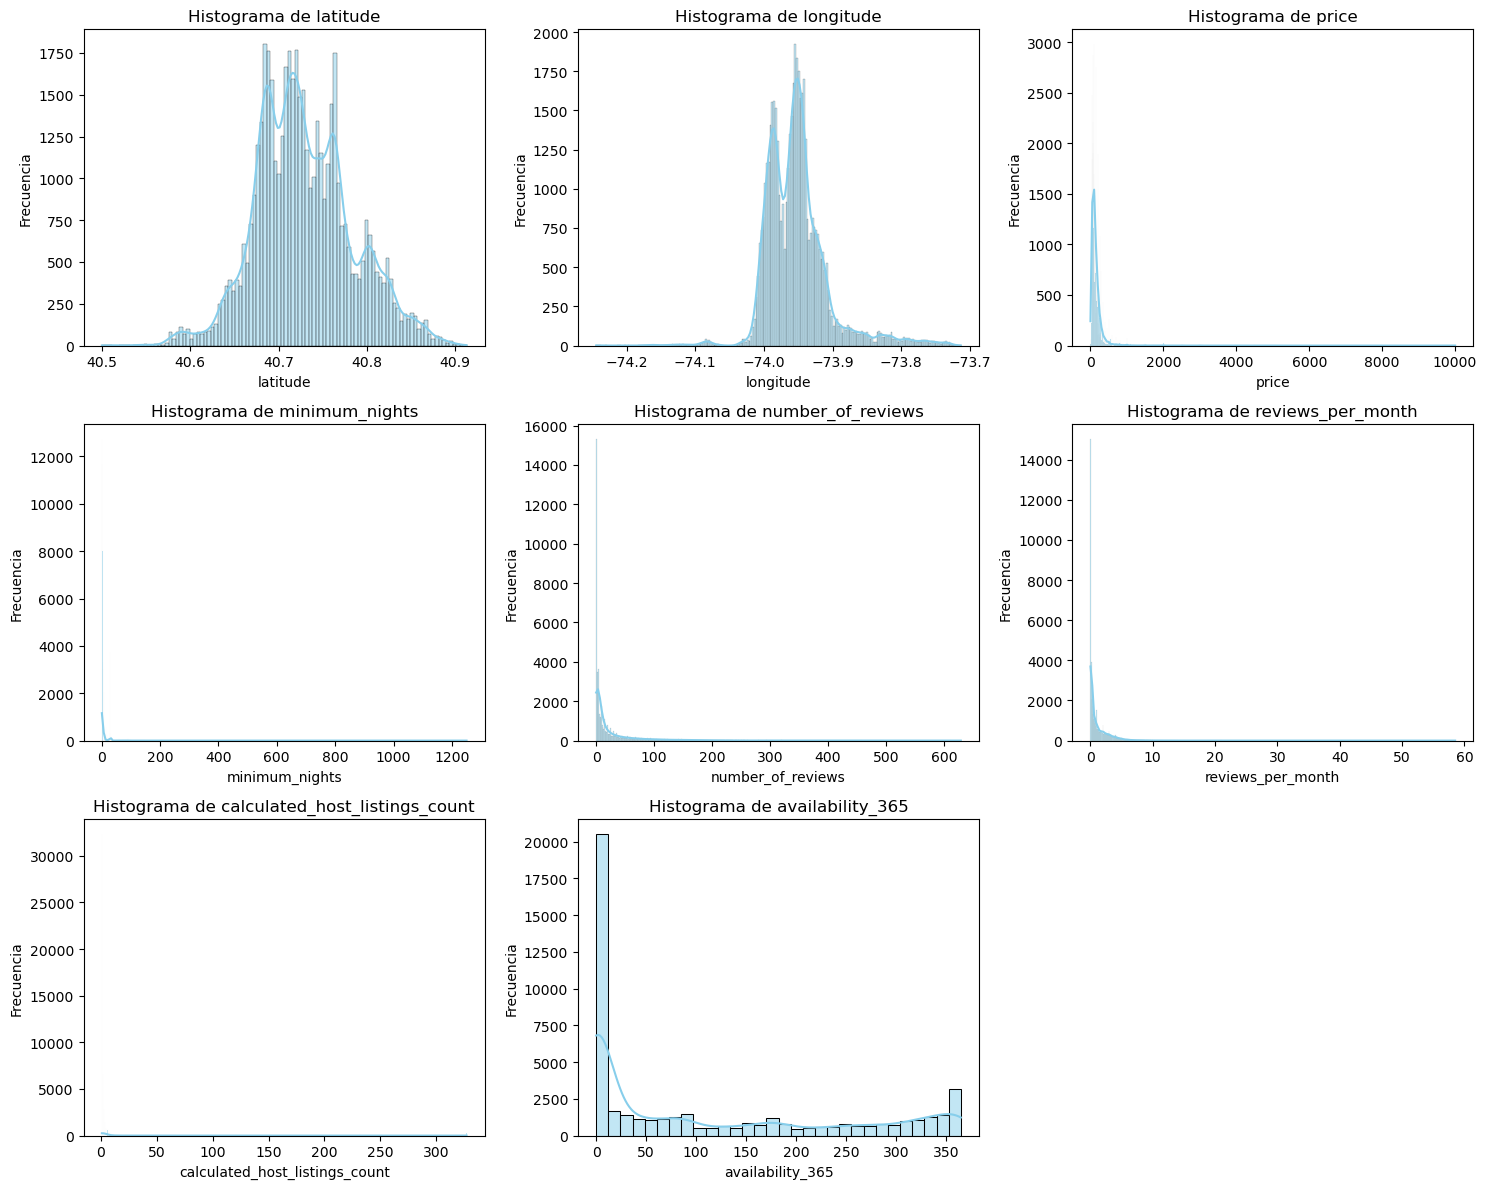

In [8]:
# 1. Histogramas para variables numéricas
num_cols = 3  # Número de columnas en la cuadrícula
num_rows = -(-len(numeric_cols) // num_cols)  # Calcula filas necesarias (redondeo hacia arriba)

# Crea la figura y los subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

# Aplana el array de ejes para facilitar el acceso
axes = axes.flatten()

# Genera los histogramas en los subplots
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Elimina cualquier subplot vacío
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

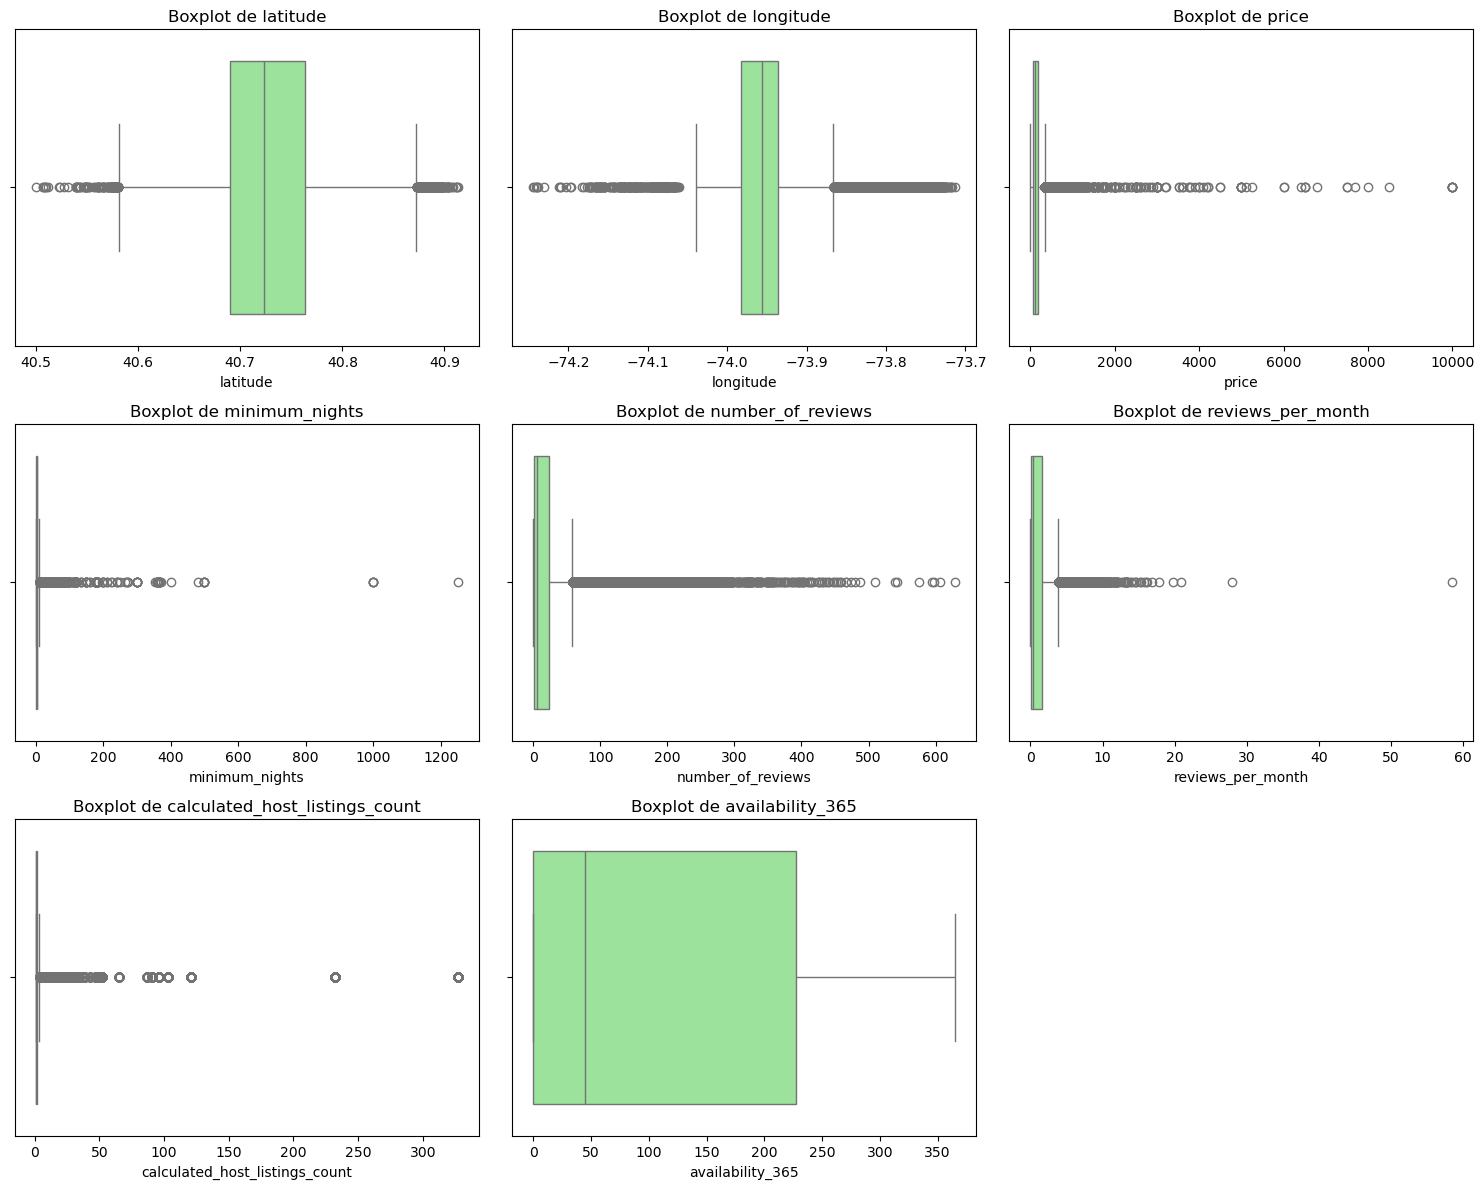

In [9]:
# 2. Boxplots para variables numéricas
num_cols = 3
num_rows = -(-len(numeric_cols) // num_cols) 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], color='lightgreen', ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
# Quitamos outliers de la columna 'Price'
# Definir el nombre de la columna a limpiar
columna = 'price'

# Calcular cuartiles
Q1 = df[columna].quantile(0.25)  # Primer cuartil (25%)
Q3 = df[columna].quantile(0.75)  # Tercer cuartil (75%)
IQR = Q3 - Q1  # Rango intercuartílico

# Definir los límites para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar eliminando los outliers
df_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
df = df_sin_outliers

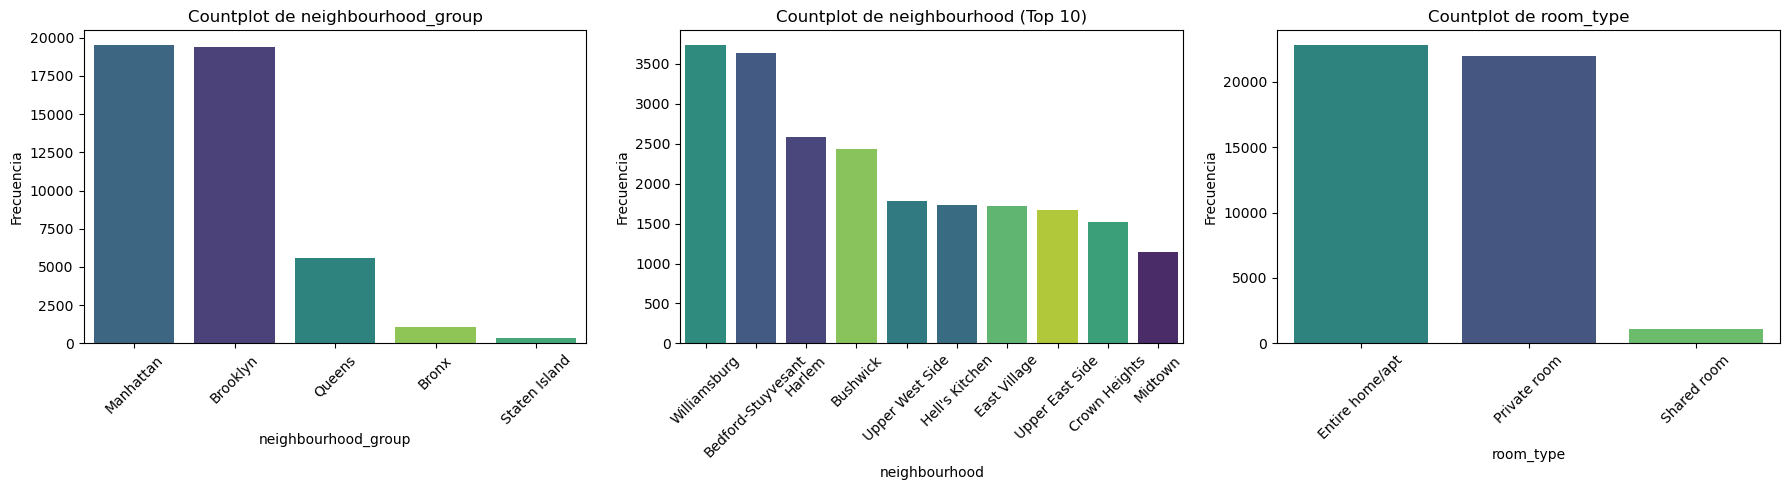

In [11]:
# 3. Countplots
# Parámetros de la cuadrícula de subplots
num_cols = 3
num_rows = -(-len(categorical_cols) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col == 'neighbourhood': 
        top_n = 10 
        top_neighbourhoods = df['neighbourhood'].value_counts().index[:top_n]
        
        sns.countplot(x=df[df['neighbourhood'].isin(top_neighbourhoods)]['neighbourhood'], 
                      order=top_neighbourhoods, hue=df[df['neighbourhood'].isin(top_neighbourhoods)]['neighbourhood'], 
                      palette='viridis', legend=False, ax=axes[i])
        axes[i].set_title('Countplot de neighbourhood (Top 10)')
    else:
        sns.countplot(x=df[col], order=df[col].value_counts().index, 
                      hue=df[col], palette='viridis', legend=False, ax=axes[i])
        axes[i].set_title(f'Countplot de {col}')

    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

   * bivariantes: scatterplot

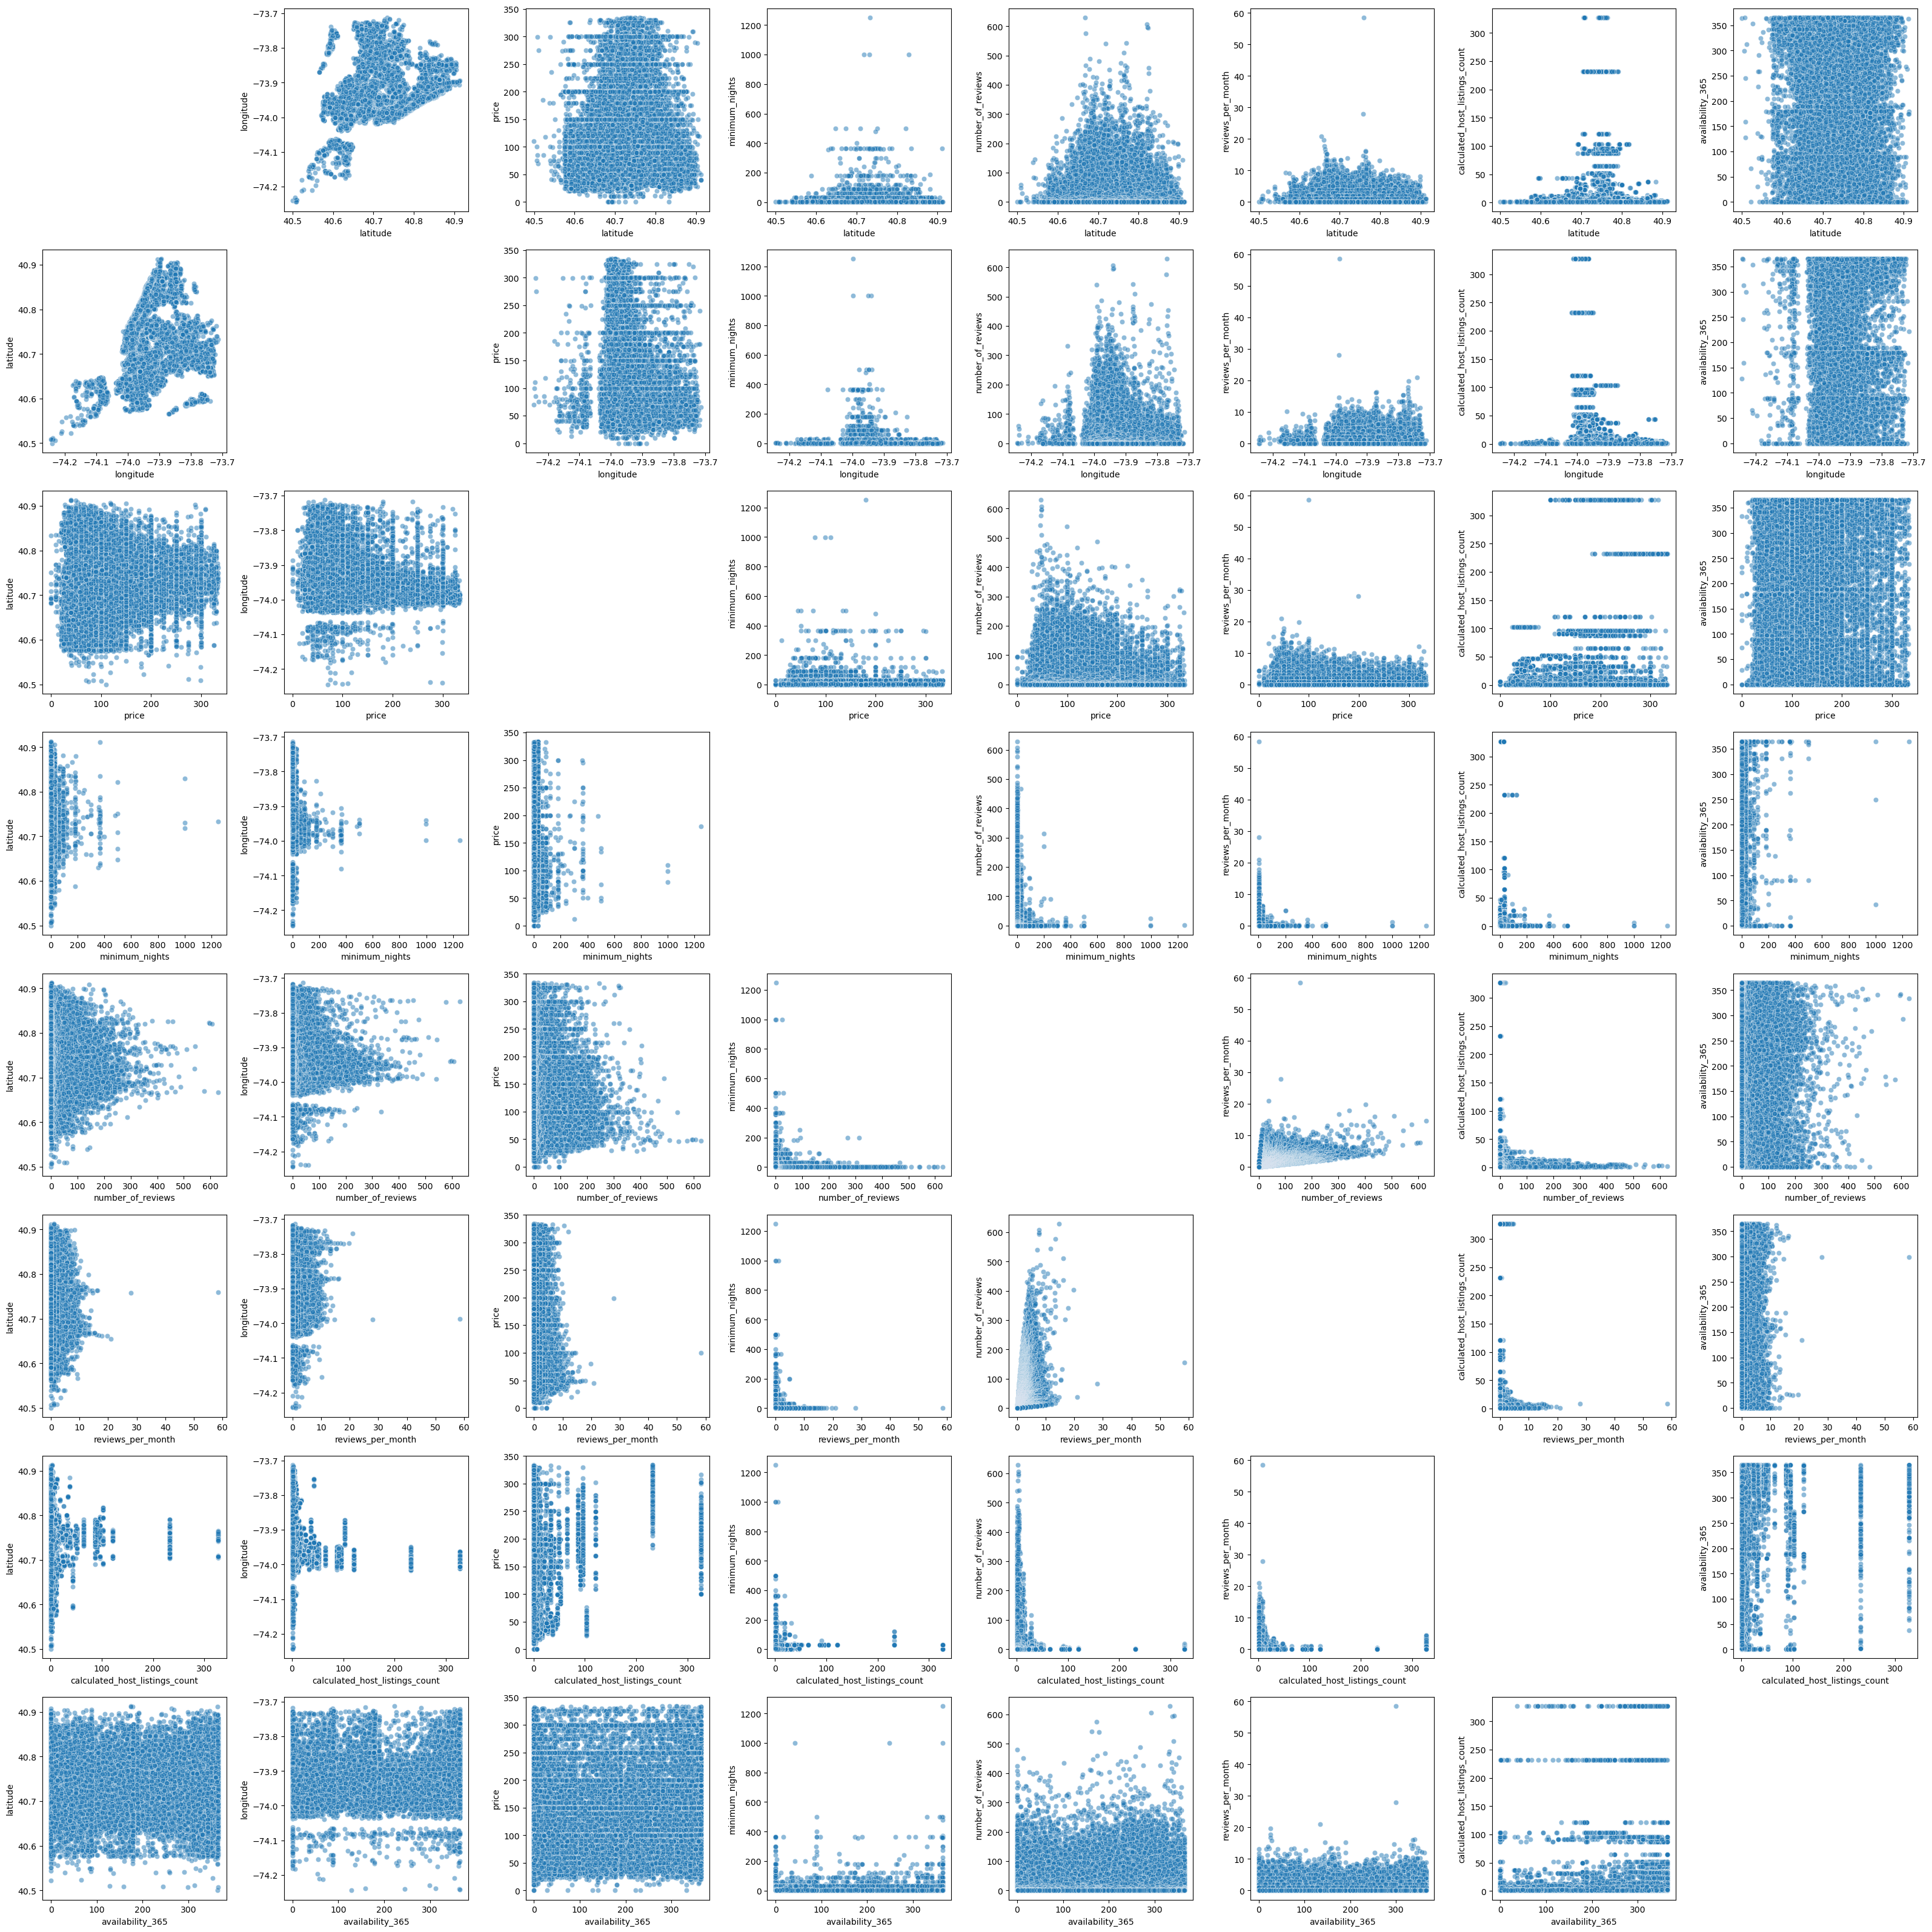

In [12]:
# Seleccionamos solo las columnas numéricas para los scatterplots
numeric_cols = df.select_dtypes(include=['number']).columns

# Generamos scatterplots
num_cols = len(numeric_cols)
fig, axes = plt.subplots(num_cols, num_cols, figsize=(num_cols * 4, num_cols * 4))

for i, col1 in enumerate(numeric_cols):
    for j, col2 in enumerate(numeric_cols):
        if i != j:  # Evitar scatterplots de la misma variable contra sí misma
            sns.scatterplot(x=df[col1], y=df[col2], ax=axes[i, j], alpha=0.5)
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)
        else:
            axes[i, j].set_visible(False)  # Ocultar la diagonal

plt.tight_layout()
plt.show()

* multivariante: corr en heatmap, pairplot

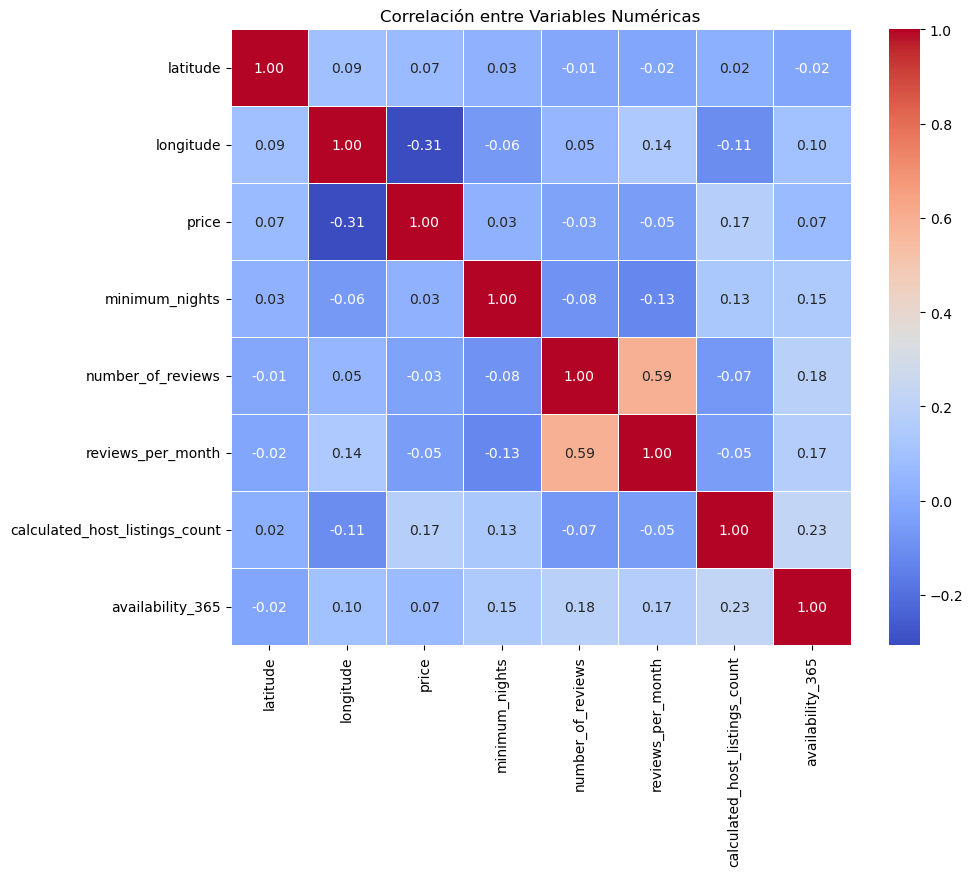

In [13]:
# Comprobamos que solo haya valores numéricos
df_numeric = df.select_dtypes(include=['number']).dropna()

# Generar Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlación entre Variables Numéricas")
plt.show()

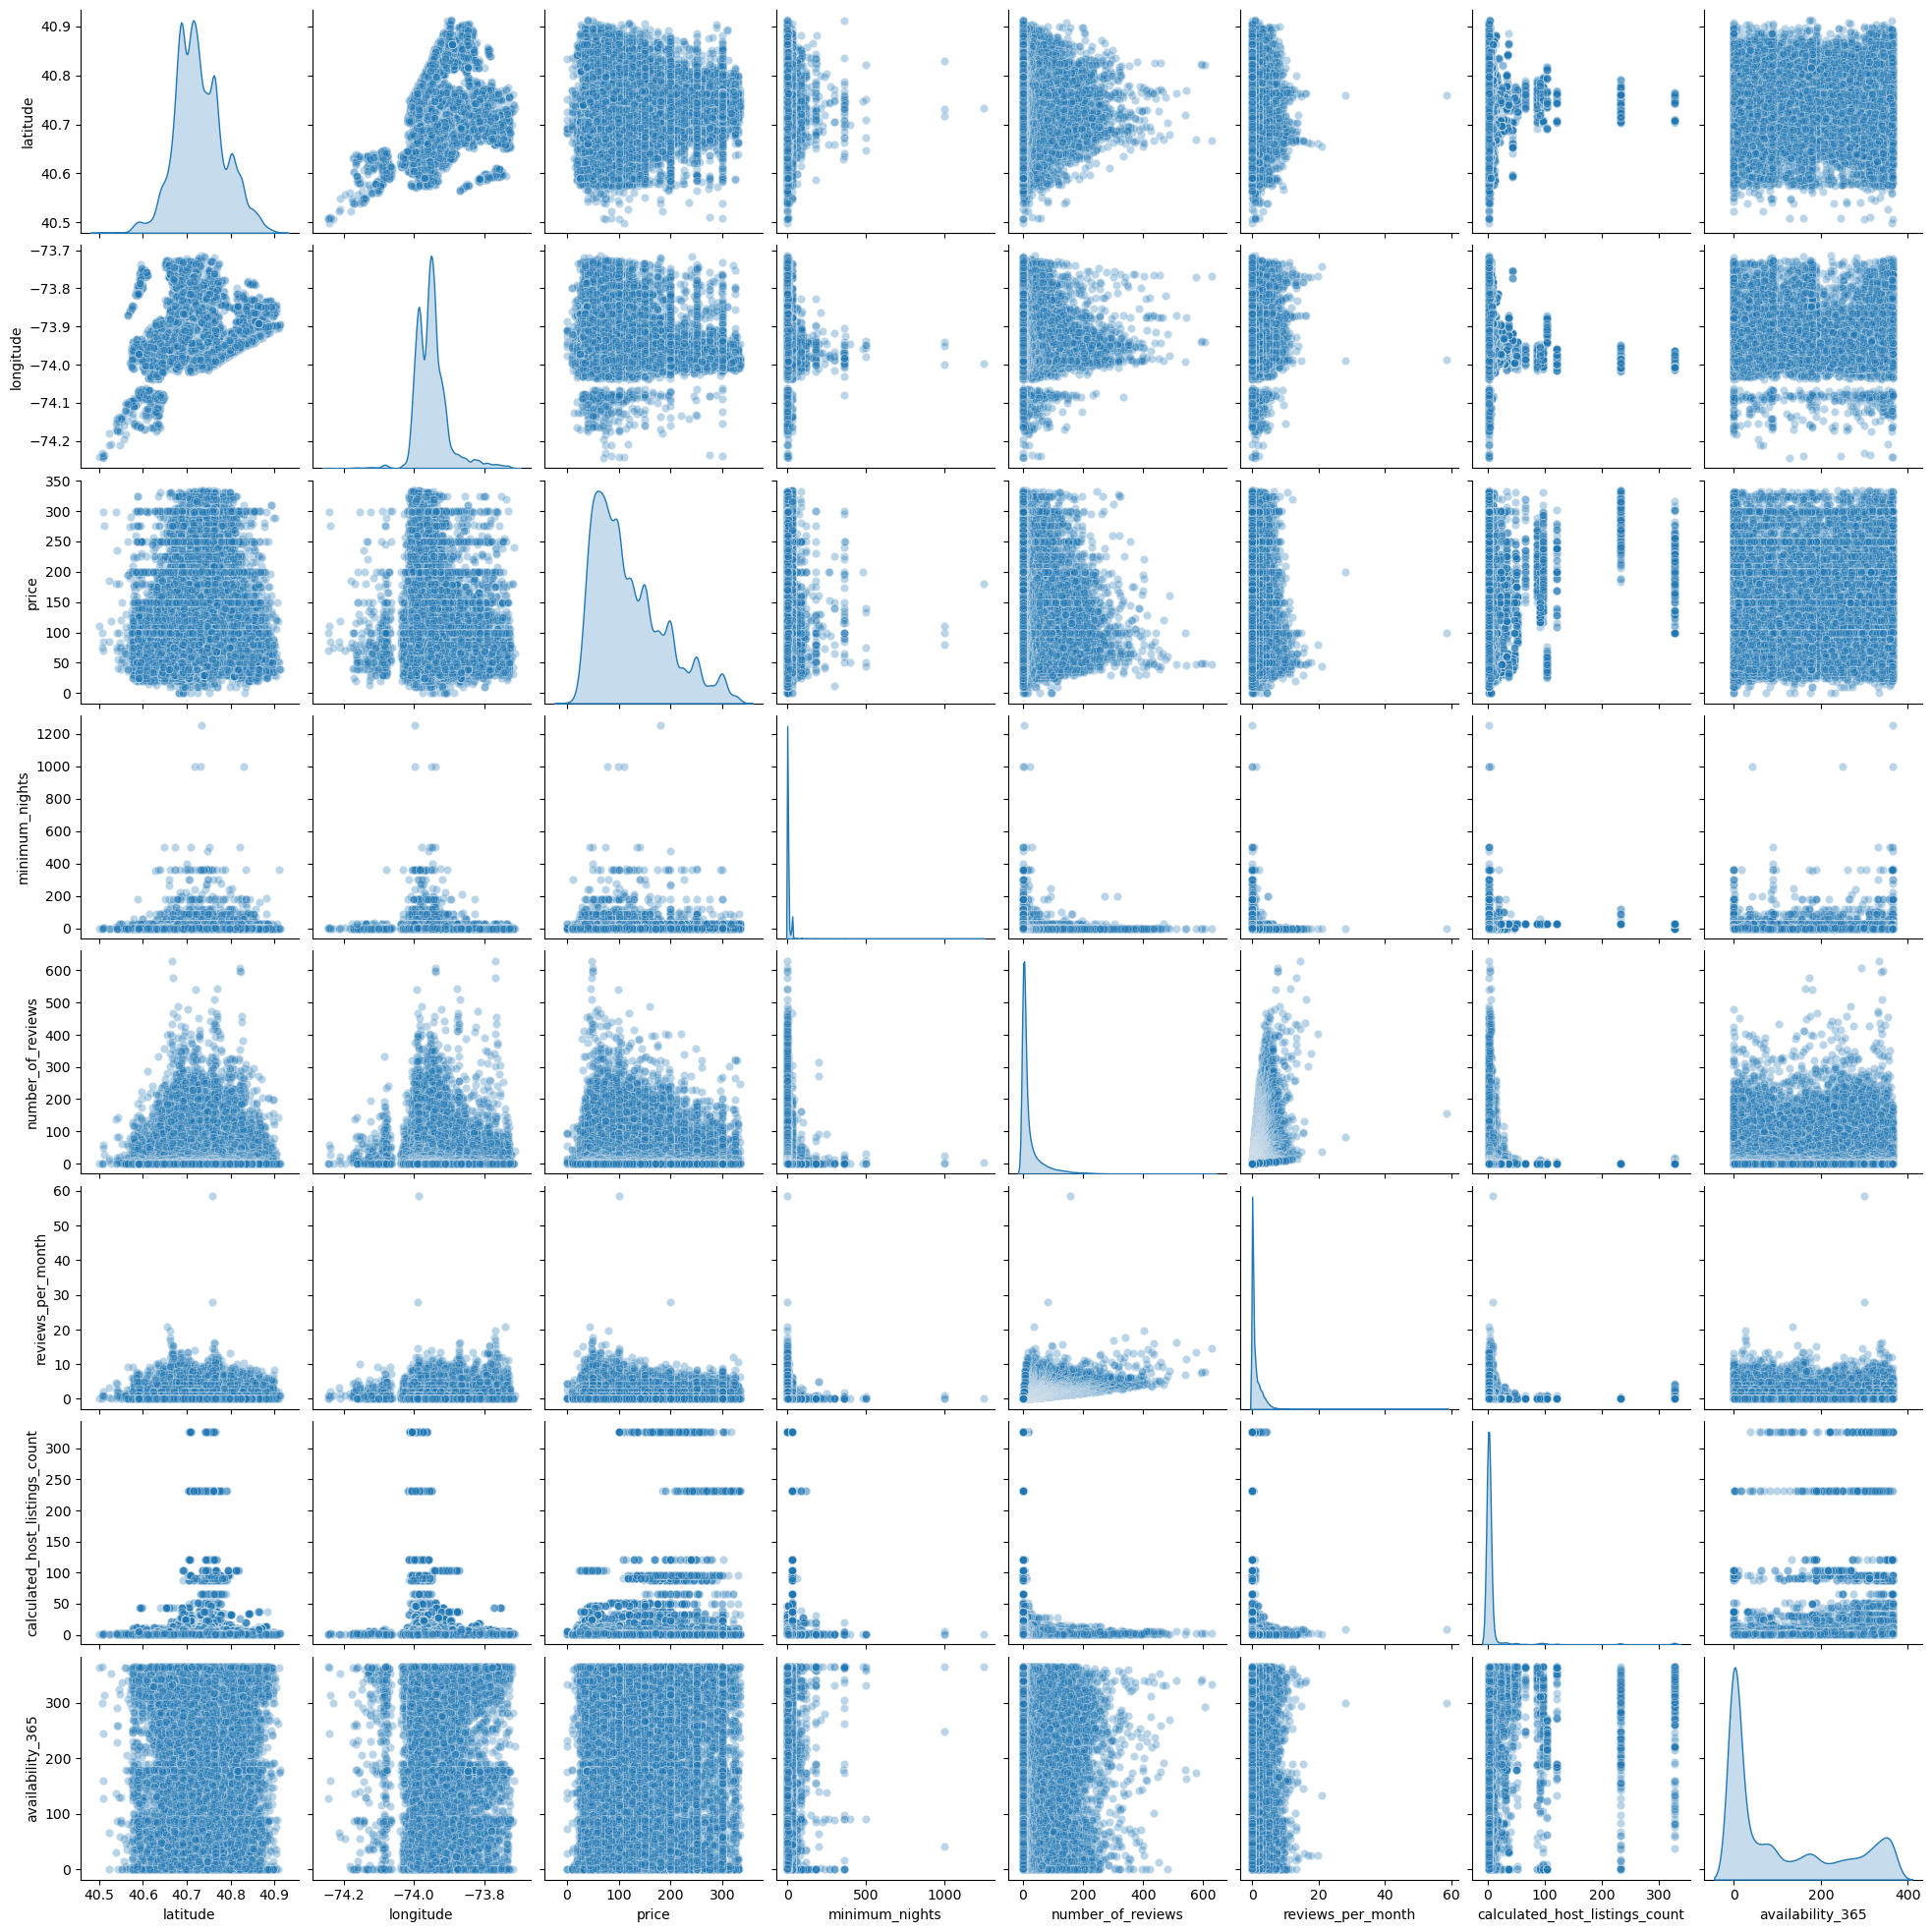

In [14]:
# Pairplot para analizar relaciones entre las variables numéricas
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.3})
plt.show()

#### Preprocesados (20%)
* numéricas: imputer, scaler, transformer
 * categóricas: imputer, encoder
    * Requisito: hacer los preprocesados con Scikit Learn en lugar de métodos de pandas

In [15]:
X = df.drop('price', axis=1) # Quitamos 'price' par ausarlo como objetivo de la prediccion
y = df['price']

# Dividimos los datos en entrenamiento(80%) y prueba(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 PASO 2: Verificar qué valores existen en `y_train` antes del filtrado
print("\nValores únicos en `y_train` antes del filtrado:")
print(y_train.unique())

print("\nValores únicos en `y_test` antes del filtrado:")
print(y_test.unique())

# Dividimos las columnas en numericas y categoricas
numerical_col = X_train.select_dtypes(include=[np.number]).columns.to_list()
categorical_col = X_train.select_dtypes(exclude=[np.number]).columns.to_list()

print('Columnas numericas', numerical_col)
print('Columnas categoricas', categorical_col)

print(f"Tamaño de X_train después de train_test_split: {X_train.shape}")
print(f"Tamaño de y_train después de train_test_split: {y_train.shape}")
print(f"Tamaño de X_test después de train_test_split: {X_test.shape}")
print(f"Tamaño de y_test después de train_test_split: {y_test.shape}")


Valores únicos en `y_train` antes del filtrado:
[ 45  75  88 275  64  81 150 300  95 120  40  60  80 130 199  53  85 175
  35  66 229  55 151 200  79  49 129  70 100  42 290  51  65 180  50  52
 125 190 195  63 110 107 185 109 235  90  99 119 160 220 320 115  30 191
  56 149  68 145 259 240  97  71  76 285 165 250 179 135  69 215  48 167
 140 325  67  98 214 218  39  89  59 155 189  46  10  74 141 142  31 105
 181 298  78 108 123 139 315  92 122 239  33 196 245 197 265 330 260 225
  96 226  22 170  36  28  58 101 169 249 144 210 102 205  94 106 133  61
 246  25 159 168  38  77 269 255  20  57 187  32  43 103 295  37  41 118
 219  93 117 310 137 152 116 209 297 136 154 128 163  83 299 146 305 309
 148  73  47 166 203 314 333 208 280 104 182 230 113 271  54 279 157 192
 143  62 156 267  86 262  34 138 147 217 270 221 172  84 233 238 177 171
  44  87  72  82  91 278  24 184 132 198 227  26  29 316 251 114 334 234
  27 183 274 264 126 174 158   0 223 153 236 263 289 121 188 178 303 306
  

In [16]:
# Creamos un Pipeline para las columnas numéricas
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputa valores NaN con la media
    ('scaler', StandardScaler()),  # Estandariza los valores (media=0, desviación estándar=1)
    ('transformer', PowerTransformer(method='yeo-johnson'))  # Transforma datos para mejorar normalidad
])

# Creamos un Pipeline para las columnas categóricas
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputa valores NaN con la moda
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Codifica en variables dummies
])

#  Combinamos los Pipelines en `ColumnTransformer`
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_col),  # Aplica el pipeline numérico a las columnas numéricas
    ('cat', categorical_pipeline, categorical_col)  # Aplica el pipeline categórico a las columnas categóricas
])

# Aplicamos el preprocesador a los datos de entrenamiento y prueba
X_train_transformed = preprocessor.fit_transform(X_train)  # Ajusta y transforma X_train
X_test_transformed = preprocessor.transform(X_test)  # Solo transforma X_test con los mismos parámetros

print("X_train después del preprocesamiento:", X_train_transformed.shape)
print("X_test después del preprocesamiento:", X_test_transformed.shape)

X_train después del preprocesamiento: (36738, 232)
X_test después del preprocesamiento: (9185, 232)


#### Clustering y siluetas (10 %)
* Crear una columna cluster usando KMeans o cualquier otro algoritmo de Clustering
* Usar esa columna para hacer algún gráfico EDA como hue para colorear con scatterplot

Silhouette Score del clustering: 0.2727


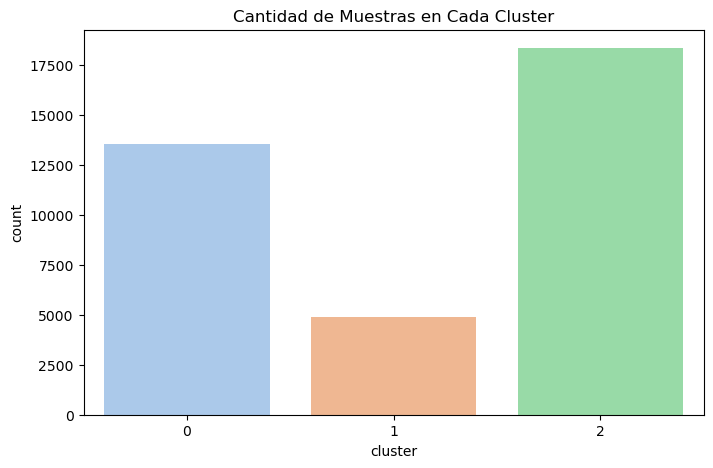

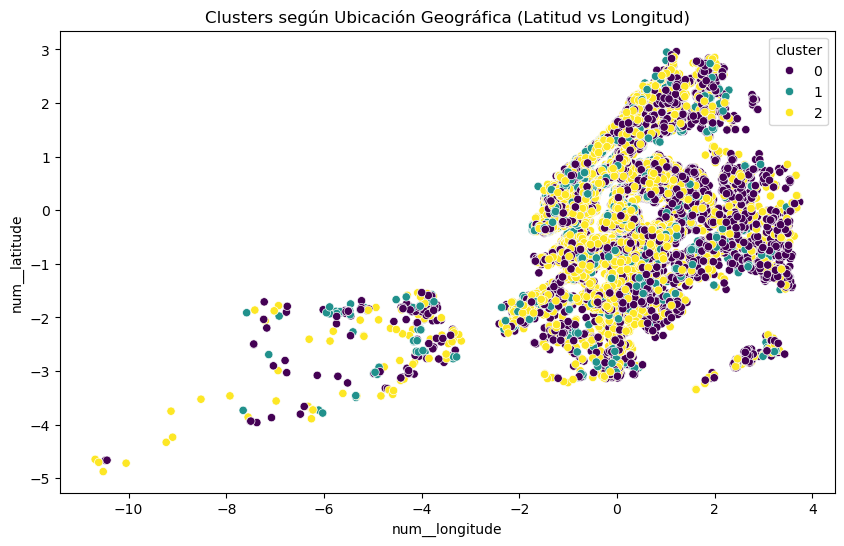

In [17]:
# Convertimos `X_train_transformed` y `X_test_transformed` en DataFrames
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

# Obtenemos las columnas numéricas después del preprocesamiento
columnas_numericas_procesadas = [col for col in X_train_df.columns if col.startswith('num__')]

# Aplicamos K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
X_train_df['cluster'] = kmeans.fit_predict(X_train_df[columnas_numericas_procesadas])
X_test_df['cluster'] = kmeans.predict(X_test_df[columnas_numericas_procesadas])  # Asigna clusters en X_test

# Evaluamos la calidad del clustering con Silhouette Score
sil_score = silhouette_score(X_train_df[columnas_numericas_procesadas], X_train_df['cluster'])
print(f"Silhouette Score del clustering: {sil_score:.4f}")

# Verificamos si las columnas de latitud y longitud cambiaron de nombre tras `ColumnTransformer`
long_col = [col for col in X_train_df.columns if 'long' in col][0]  # Busca la columna de longitud
lat_col = [col for col in X_train_df.columns if 'lat' in col][0]  # Busca la columna de latitud

# Histograma de la cantidad de datos por cluster 
plt.figure(figsize=(8, 5))
sns.countplot(data=X_train_df, x='cluster', hue='cluster', palette='pastel', legend=False)
plt.title("Cantidad de Muestras en Cada Cluster")
plt.show()

# Scatterplot para visualizar la distribucion de los clusters geográficamente
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_train_df, x=long_col, y=lat_col, hue='cluster', palette='viridis')
plt.title("Clusters según Ubicación Geográfica (Latitud vs Longitud)")
plt.show()

* feature selection (10%)
* SelectKBest para filtrar las mejores columnas y probar - Probar este para regresión
    * PCA - Probar este para clasificación
    * probar los dos pero quedarse con uno, o comparar resultados con ambos
    * Hay pocas columnas, por lo que esta fase no sería tan relevante

In [18]:
# Buscamos el número máximo de columnas disponibles
num_features = len(columnas_numericas_procesadas)  # Número real de columnas numéricas

# Ajustamos k dinámicamente
k = min(10, num_features)  # Si hay menos de 10 columnas usa todas las disponibles

# Aplicamos SelectKBest para filtrar las mejores columnas
selector = SelectKBest(score_func=f_regression, k=k)
X_train_kbest = selector.fit_transform(X_train_df[columnas_numericas_procesadas], y_train)
X_test_kbest = selector.transform(X_test_df[columnas_numericas_procesadas])

# Obtenemos las columnas seleccionadas
selected_features = X_train_df[columnas_numericas_procesadas].columns[selector.get_support()]
print(f"{len(selected_features)} Mejores columnas seleccionadas por SelectKBest:")
print(selected_features)

7 Mejores columnas seleccionadas por SelectKBest:
Index(['num__latitude', 'num__longitude', 'num__minimum_nights',
       'num__number_of_reviews', 'num__reviews_per_month',
       'num__calculated_host_listings_count', 'num__availability_365'],
      dtype='object')


In [19]:
#  Obtenemos el número de columnas numéricas disponibles
num_features_pca = len(columnas_numericas_procesadas)

# Ajustamos n_components dinámicamente
n_components = min(10, num_features_pca)

# Aplicamos PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_df[columnas_numericas_procesadas])
X_test_pca = pca.transform(X_test_df[columnas_numericas_procesadas])

# Mostramos la varianza por cada columna
print("Varianza explicada por cada componente PCA:")
print(pca.explained_variance_ratio_)

# Mostramos la varianza total retenida
print(f"Varianza total retenida con {n_components} componentes: {sum(pca.explained_variance_ratio_):.4f}")


Varianza explicada por cada componente PCA:
[0.29599185 0.21764023 0.16233954 0.12330253 0.09806038 0.07271538
 0.0299501 ]
Varianza total retenida con 7 componentes: 1.0000


* Regresión (20%):
    * Predecir la columna 'price'

In [20]:
# 🔹 Entrenar el modelo de regresión con las mejores características seleccionadas por SelectKBest
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_kbest, y_train)

# 🔹 Predecir el precio en los datos de prueba
y_pred = regressor.predict(X_test_kbest)

# 🔹 Evaluar el modelo con métricas de regresión
mae = mean_absolute_error(y_test, y_pred) # Promedio de error en predecir el precio en dolares
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluación del Modelo de Regresión Usando SelectKBest:")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

Evaluación del Modelo de Regresión Usando SelectKBest:
MAE (Error Absoluto Medio): 41.54
MSE (Error Cuadrático Medio): 3046.99
RMSE (Raíz del Error Cuadrático Medio): 55.20
R2 Score: 0.3459


#### Vemos que R2 es bajo
* Se podria probar a ajustar k en SelectKBest, aunque ya esta usando el maximo de columnas disponibles.
* Probar con otros modelos(LinearRegression, GradientBoosting, XGBoost).

* Clasificación multiclase (20%)
    * Predecir la columna 'room_type'

In [21]:
X = df.drop(columns=['room_type'])  # Quitamos 'room_type' de las características
y = df['room_type']  # La variable objetivo es 'room_type'

# 🔹 Dividir en conjunto de entrenamiento y prueba (Clasificación de room_type)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 PASO 2: Verificar qué valores existen en `y_train` antes del filtrado
print("\nValores únicos en `y_train` antes del filtrado:")
print(y_train.unique())

print("\nValores únicos en `y_test` antes del filtrado:")
print(y_test.unique())

# Dividimos las columnas en numericas y categoricas
numerical_col = X_train.select_dtypes(include=[np.number]).columns.to_list()
categorical_col = X_train.select_dtypes(exclude=[np.number]).columns.to_list()

print('Columnas numericas', numerical_col)
print('Columnas categoricas', categorical_col)

print(f"Tamaño de X_train después de train_test_split: {X_train.shape}")
print(f"Tamaño de y_train después de train_test_split: {y_train.shape}")
print(f"Tamaño de X_test después de train_test_split: {X_test.shape}")
print(f"Tamaño de y_test después de train_test_split: {y_test.shape}")


Valores únicos en `y_train` antes del filtrado:
['Private room' 'Entire home/apt' 'Shared room']

Valores únicos en `y_test` antes del filtrado:
['Private room' 'Entire home/apt' 'Shared room']
Columnas numericas ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Columnas categoricas ['neighbourhood_group', 'neighbourhood']
Tamaño de X_train después de train_test_split: (36738, 10)
Tamaño de y_train después de train_test_split: (36738,)
Tamaño de X_test después de train_test_split: (9185, 10)
Tamaño de y_test después de train_test_split: (9185,)


In [22]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 🔹 Convertir 'room_type' en valores numéricos
label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train)  # Entrenar el encoder con las clases de y_train

# 🔹 Asegurar que solo transformamos valores conocidos en y_test
y_test_class = np.array([label_encoder.transform([val])[0] if val in label_encoder.classes_ else -1 for val in y_test])

# 🔹 Mostrar las clases codificadas
print("\nClases de room_type codificadas:", list(label_encoder.classes_))

# 🔹 Verificar si hay valores no vistos en y_test
num_unseen = sum(y_test_class == -1)
if num_unseen > 0:
    print(f"Se encontraron {num_unseen} valores en `y_test` que no estaban en `y_train`.")
    print("Estos valores han sido codificados como `-1`.")


Clases de room_type codificadas: ['Entire home/apt', 'Private room', 'Shared room']


In [23]:
# 🔹 Filtrar solo columnas numéricas en X_train y X_test antes de PCA
X_train_numeric = X_train.select_dtypes(include=['number'])
X_test_numeric = X_test.select_dtypes(include=['number'])

# 🔹 Verificar qué columnas quedan
print("\nColumnas usadas en PCA (solo numéricas):")
print(X_train_numeric.columns)

# 🔹 Aplicar PCA solo a columnas numéricas
n_components = min(10, X_train_numeric.shape[1])  # No puede ser mayor que el número de columnas

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_numeric)
X_test_pca = pca.transform(X_test_numeric)

# 🔹 Mostrar la varianza retenida
print("\nVarianza explicada por cada componente PCA:")
print(pca.explained_variance_ratio_)

print(f"\nVarianza total retenida con {n_components} componentes: {sum(pca.explained_variance_ratio_):.4f}")



Columnas usadas en PCA (solo numéricas):
Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

Varianza explicada por cada componente PCA:
[6.84283136e-01 1.85081779e-01 8.06945294e-02 3.47230099e-02
 1.51503789e-02 6.69681657e-05 1.25933790e-07 7.26086487e-08]

Varianza total retenida con 8 componentes: 1.0000


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 🔹 Entrenar el modelo con datos reducidos por PCA
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_pca, y_train_class)

# 🔹 Hacer predicciones
y_pred_class = classifier.predict(X_test_pca)

# 🔹 Evaluar el modelo
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"\n📊 Accuracy del Modelo de Clasificación: {accuracy:.4f}")

# 🔹 Reporte de clasificación
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_class, y_pred_class, target_names=label_encoder.classes_))



📊 Accuracy del Modelo de Clasificación: 0.8466

📊 Reporte de Clasificación:
                 precision    recall  f1-score   support

Entire home/apt       0.85      0.87      0.86      4558
   Private room       0.84      0.85      0.84      4399
    Shared room       0.83      0.29      0.43       228

       accuracy                           0.85      9185
      macro avg       0.84      0.67      0.71      9185
   weighted avg       0.85      0.85      0.84      9185



* Comparar resultados de modelos con validación cruzada (10 %)
    * Mostrar un dataframe de resultados con las métricas calculadas
    * Opcional: mostrar boxplot de los resultados de validación cruzada como tiempos de ejecución y predicción y métricas

In [26]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pandas as pd
import time

# 🔹 Definir los modelos a comparar
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
}

# 🔹 Diccionario para almacenar resultados
resultados = []

# 🔹 Validación cruzada en cada modelo
for nombre, modelo in modelos.items():
    start_time = time.time()
    
    scores = cross_validate(modelo, X_train_pca, y_train_class, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], return_train_score=False)
    
    exec_time = time.time() - start_time  # Tiempo de ejecución
    
    resultados.append({
        "Modelo": nombre,
        "Accuracy": scores['test_accuracy'].mean(),
        "Precision": scores['test_precision_weighted'].mean(),
        "Recall": scores['test_recall_weighted'].mean(),
        "F1-score": scores['test_f1_weighted'].mean(),
        "Tiempo (s)": exec_time
    })

# 🔹 Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# 🔹 Mostrar los resultados en un DataFrame
# 🔹 Mostrar los resultados en un DataFrame
import pandas as pd
from IPython.display import display

display(df_resultados)


Modelo  Accuracy  Precision    Recall  F1-score  Tiempo (s)
0      RandomForest  0.846780   0.847792  0.846780  0.842756   47.814105
1  GradientBoosting  0.847379   0.845120  0.847379  0.843390  198.613689
2           XGBoost  0.851843   0.851024  0.851843  0.848914    3.780555

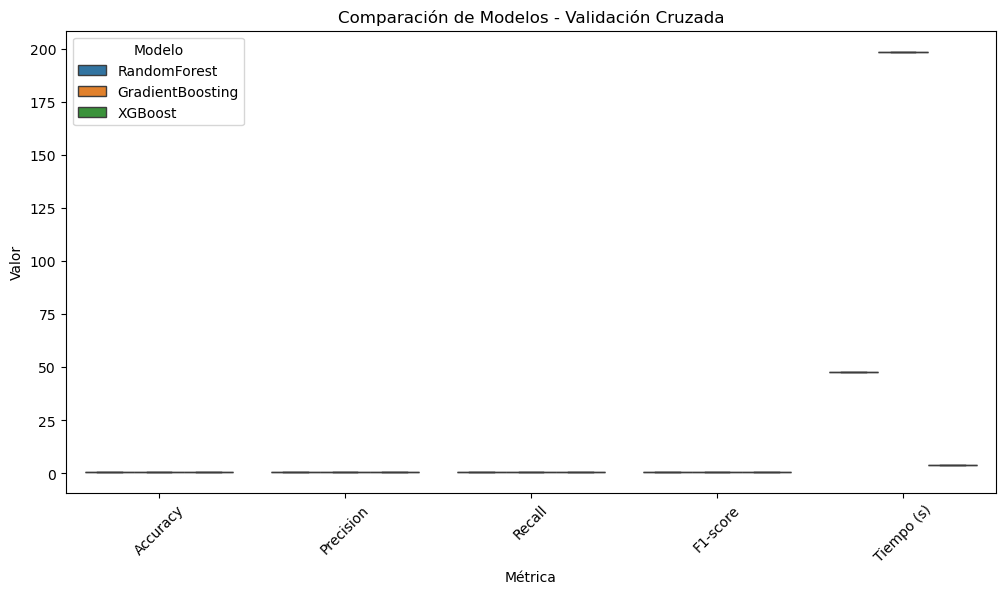

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Convertir DataFrame a formato largo para graficar
df_long = df_resultados.melt(id_vars=["Modelo"], value_vars=["Accuracy", "Precision", "Recall", "F1-score", "Tiempo (s)"])

# 🔹 Crear boxplot de métricas
plt.figure(figsize=(12, 6))
sns.boxplot(x="variable", y="value", hue="Modelo", data=df_long)
plt.title("Comparación de Modelos - Validación Cruzada")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.xticks(rotation=45)
plt.show()
